In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
#using matplotlib’s ggplot style
plt.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition,linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier,Lasso,LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,f1_score,roc_auc_score,precision_recall_curve,roc_curve,auc
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC  
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time

In [5]:
path ='D:/python_notebook/capstone/'

### state level data

In [6]:
%%capture
# if do lag prediction we would remove district of columbia first

In [7]:
total = pd.read_csv(path + 'final_data(industry not added).csv')
extra_data1=pd.read_csv('./extra_feature1.csv')
extra_data2=pd.read_csv('./extra_feature2.csv')
extra_data=pd.merge(extra_data1,extra_data2,on=['year','state'],how='outer')
total=pd.merge(total,extra_data,on=['year','state'],how='left')
total=total.loc[total.GeoName!='District of Columbia',:]
total_merge=total.copy()


In [8]:
#generate target variable
new_target=pd.read_csv('./tagert.csv')
new_target=new_target.drop_duplicates()
'''
new_target['opn']=(new_target.open_establish-new_target.end_establish)>0
new_target['exp']=(new_target.expand_establish-new_target.contract_establish)>0
new_target['total_exp']=(new_target.total_expand-new_target.total_contract)>0
'''
def generate_target(threshold,total_merge):
    new_target=pd.read_csv('./tagert.csv')
    new_target=new_target.drop_duplicates()
    new_target['opn']=(new_target.open_establish-new_target.end_establish)/new_target.open_establish>threshold
    new_target['exp']=(new_target.expand_establish-new_target.contract_establish)/new_target.expand_establish>threshold
    new_target['total_exp']=(new_target.total_expand-new_target.total_contract)/new_target.total_expand>threshold
    new_target=new_target[['state','year','opn','exp','total_exp']]
    multi_target=pd.DataFrame(new_target.groupby(['state','year'])[['opn','exp','total_exp']].sum()).reset_index()
    multi_target[['opn','exp','total_exp']]=(multi_target[['opn','exp','total_exp']]>=2).astype(int)
    multi_class_df=pd.merge(total_merge,multi_target,on=['year','state'],how='inner')
    multi_class_df=multi_class_df.loc[multi_class_df.state!='District of Columbia',:]
    target_df=multi_class_df[['exp','opn','total_exp','GeoName','year']]
    target_df=target_df.reset_index(drop=True)
    target_df =target_df.set_index(['year'])
    return target_df


### Correlation Matrix with Features

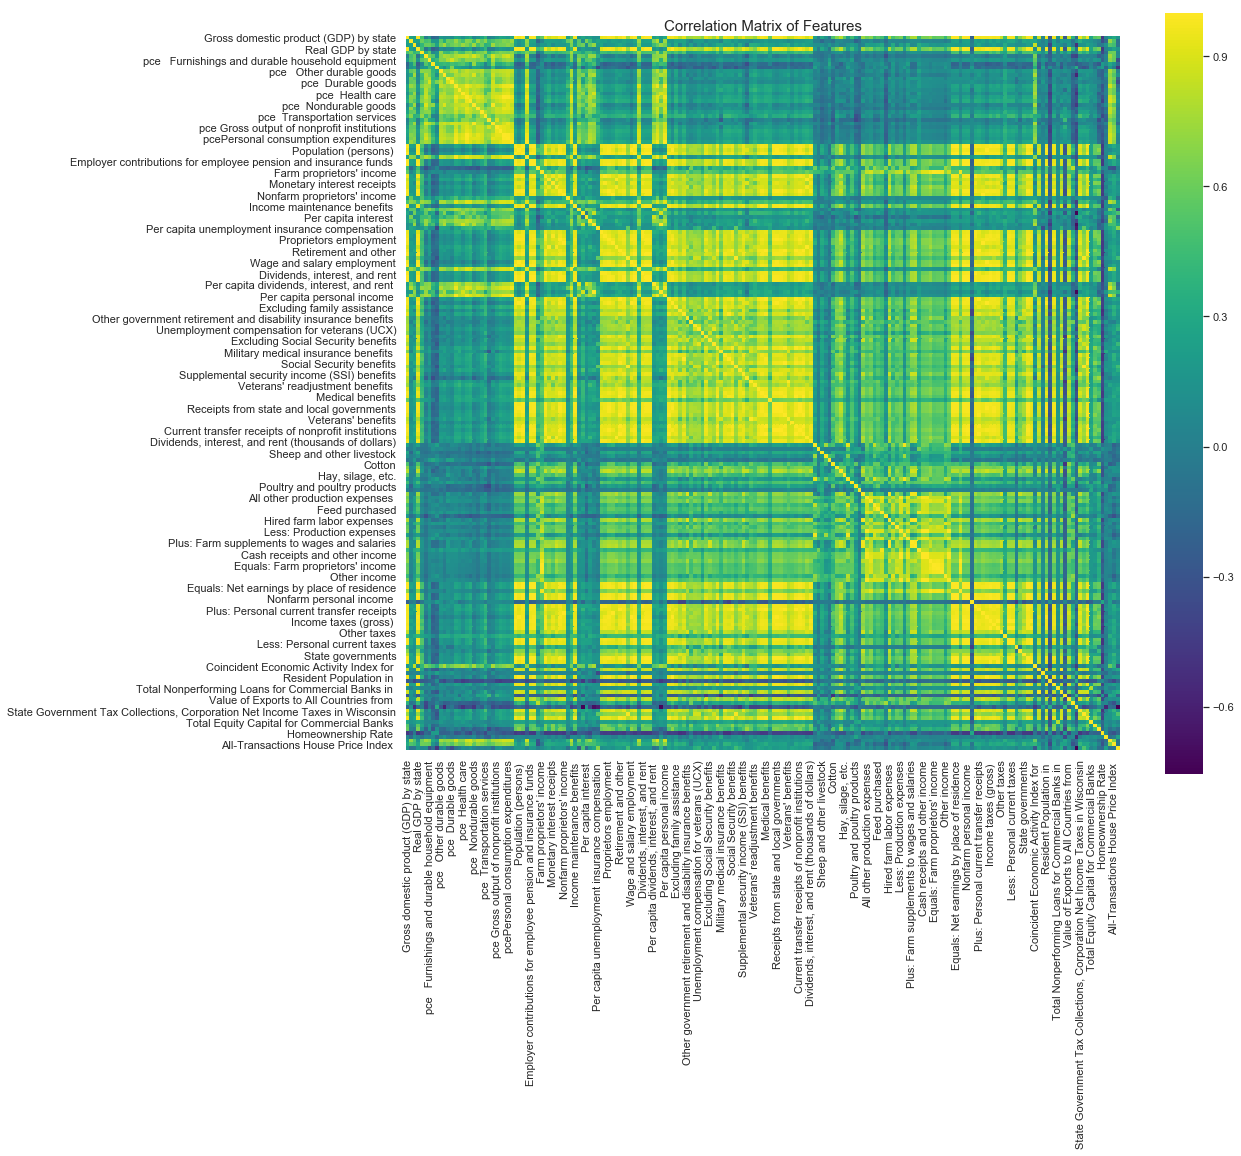

In [9]:
features =total.drop(columns=['contract_establish','expand_establish','end_establish',
                              'net_change','open_establish','total_contract','total_expand',
                              'GeoName','state','year'])

f, ax = plt.subplots(figsize = (16,14))
plt.title('Correlation Matrix of Features', size = 15)
sns.heatmap(features.corr(), square=True, vmax=1, cmap='viridis')

In [10]:
print('feature number before dropping multicollinearity',features.shape)
corr_matrix =features.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Drop features 
final_features =features.drop(columns=to_drop, axis=1)
print('feature number after dropping multicollinearity',final_features.shape)

feature number before dropping multicollinearity (1000, 213)
feature number after dropping multicollinearity (1000, 123)


In [11]:
%%capture
#This block of codes is checking whether the max or min of each column is in normal range to identify outliers if exist
'''
for column in final_features.columns:
    temp_column=final_features[column]
    value_count=temp_column.value_counts()
    value_count=value_count.sort_values(ascending=False)
    number_over=value_count[value_count>25]
    if len(number_over)>0 and number_over.sum()>50 and len(number_over)<5 and value_count[value_count>25].index[0]!='(NA)' and value_count[value_count>25].index[0]!='(L)' :
        print(number_over)
    try:
        temp97_percentile=temp_column[temp_column>temp_column.quantile(0.97)]
        if temp97_percentile.mean()>10*temp_column.mean():
            print((column,temp97_percentile.mean(),temp97_percentile.max(),temp_column.mean()))
    except:
        print(column,'bad_column')
'''
    


### Lagged Data Analysis

SME target lagged label -- value changed based on values in this year minus values in previus year

In [12]:
state_list =total.GeoName.unique().tolist()
total =total.drop(columns =['contract_establish','expand_establish','end_establish',
                              'net_change','open_establish','total_contract','total_expand'])
print('dropping high correlation features')
print(total.shape)
total =total.drop(columns=to_drop, axis=1)
print(total.shape)
print('dropping process finished the final feature numbers')

dropping high correlation features
(1000, 216)
(1000, 126)
dropping process finished the final feature numbers


In [13]:
def clean_state_data(total):
    #df_1 =total_3.loc[total_3['GeoName'] == st_name]
    df =total.copy()
    df =df.set_index(['GeoName','year'])
    df =df.replace({'(NA)': np.nan ,'(L)':np.nan ,0:np.nan})
    df =df.drop(columns =['state'])
    #check missing value 
    miss_col = df
    miss_col = miss_col.isnull().sum(axis =0)/float(len(miss_col))
    miss_col =miss_col.sort_values(ascending=False)
    columns = df.columns
    missing_value_df = pd.DataFrame({'percent_missing': miss_col})
    missing_value_df['percent_missing'] =missing_value_df['percent_missing'].astype('float64')
    
    miss_col =missing_value_df.loc[(missing_value_df['percent_missing'] >0) 
                               &(missing_value_df['percent_missing'] <0.3)].index.tolist()  
    #drop columns with large missing
    del_list = missing_value_df.loc[(missing_value_df['percent_missing'] >=0.3)].index.tolist()
    df = df.drop(columns=del_list)
    df=df.astype(float)
    df=df.apply(lambda x: x.fillna(x.mean()),axis=0)
    df_2 = df.copy()
    #numerical feature scaling
    scaler = MinMaxScaler()
    col =df_2.columns.values
    df_2[col] = scaler.fit_transform(df_2[col]) 
    return df_2

In [14]:
total =clean_state_data(total)

##  Adding change rate and velocity of change

In [15]:
state_group=total.groupby('GeoName')
group_count=0
for name, group in state_group:
    shift1=group.shift(-1)
    shift2=group.shift(-2)
    change_rate=shift1-group
    velocity_rate=shift2-shift1
    change_rate=change_rate.reset_index()
    velocity_rate=velocity_rate.reset_index()
    change_rate['year']=list(range(1998,2018,1))
    velocity_rate['year']=list(range(1999,2019,1))
    change_col_name=[x if x=='GeoName' or x=='year' else 'change_rate:'+x for x in change_rate.columns ]
    change_rate.columns=change_col_name
    velocity_col_name=[x if x=='GeoName' or x=='year' else 'velocity of change:'+x for x in velocity_rate.columns ]
    velocity_rate.columns=velocity_col_name
    if group_count==0:
        change_rate_df=change_rate
        velocity_rate_df=velocity_rate
    else:
        change_rate_df=change_rate_df.append(change_rate)
        velocity_rate_df=velocity_rate_df.append(velocity_rate)
    group_count+=1  
total_1year=pd.merge(total,change_rate_df,on=['GeoName','year'],how='inner')
total_2year=pd.merge(total_1year,velocity_rate_df,on=['GeoName','year'])

In [16]:
def generate_X(total,lag_year):
    total=total.set_index(['GeoName','year'])
    total=total.reset_index(level='GeoName')
    x_train_1 =total.loc[list(range(1997+lag_year,2012))]
    x_test_1 =total.loc[[2012,2013,2014,2015]]
    x_train =x_train_1.drop(columns =['GeoName'])
    x_test  =x_test_1.drop(columns =['GeoName'])
    x_predict=total.loc[[2016]]
    print(x_train.shape)
    print(x_test.shape)
    return x_train,x_test




In [17]:

#split train and test data
def get_label(target_df,col_name,lag_year):
    y_train=target_df.loc[list(range(1997+lag_year,2012)),col_name]
    y_test =target_df.loc[[2013,2014,2015,2016],col_name]
    return y_train,y_test




def parameter_tunning(model,parameter_dict,x_train,y_train):
    grid_clf = GridSearchCV(model, parameter_dict, cv=5,scoring='f1',n_jobs=4)
    gcv=grid_clf.fit(x_train, y_train)
    best_parameters=gcv.best_params_
    best_scores=gcv.best_score_
    #print(best_scores)
    return best_parameters


## performance evaluation

In [18]:
def perfomance_model(x_train,y_train,x_test,y_test,classifier):
    classifier.fit(x_train,y_train)
    y_test_pred=classifier.predict(x_test)
    y_train_pred=classifier.predict(x_train)
    train_acc=accuracy_score(y_train,y_train_pred)
    test_acc =accuracy_score(y_test, y_test_pred)
    #train_f1=f1_score(y_train,y_train_pred,average='weighted')
    #test_f1=f1_score(y_test,y_test_pred,average='weighted')
    train_f1=f1_score(y_train,y_train_pred)
    test_f1=f1_score(y_test,y_test_pred)
    return test_acc,test_f1


In [19]:
def generate_peformance_df():
    acc1=[svm1_acc,rfc1_acc,xgb1_acc]
    f11=[svm1_f1,rfc1_f1,xgb1_f1]
    acc2=[svm2_acc,rfc2_acc,xgb2_acc]
    f12=[svm2_f1,rfc1_f1,xgb2_f1]
    performance_df=pd.DataFrame({'accuracy for change rate':acc1,'f1 for change rate':f11,
              'accuracy with velocity':acc2,'f1 with velocity':f12})
    performance_df.index=['svm','random forest','XGboost']
    return performance_df

In [20]:
x_train_1,x_test_1=generate_X(total_1year,1)
x_train_2,x_test_2=generate_X(total_2year,2)

def generate_target_dict(target_df):
    y_train_exp_2,y_test_exp_2=get_label(target_df,'exp',2)
    y_train_opn_2,y_test_opn_2=get_label(target_df,'opn',2)
    y_train_total_2,y_test_total_2=get_label(target_df,'total_exp',2)
    y_train_exp_1,y_test_exp_1=get_label(target_df,'exp',1)
    y_train_opn_1,y_test_opn_1=get_label(target_df,'opn',1)
    y_train_total_1,y_test_total_1=get_label(target_df,'total_exp',1)
    target_dict={'exp':{'x_train_1':x_train_1,'x_train_2':x_train_2,
                        'x_test_1':x_test_1,'x_test_2':x_test_2,
                        'y_train_1':y_train_exp_1,'y_train_2':y_train_exp_2,
                        'y_test_1':y_test_exp_1,'y_test_2':y_test_exp_2},
                'opn':{'x_train_1':x_train_1,'x_train_2':x_train_2,
                       'x_test_1':x_test_1,'x_test_2':x_test_2,
                        'y_train_1':y_train_opn_1,'y_train_2':y_train_opn_2,
                        'y_test_1':y_test_opn_1,'y_test_2':y_test_opn_2},
                'total':{'x_train_1':x_train_1,'x_train_2':x_train_2,
                         'x_test_1':x_test_1,'x_test_2':x_test_2,
                        'y_train_1':y_train_total_1,'y_train_2':y_train_total_2,
                        'y_test_1':y_test_total_1,'y_test_2':y_test_total_2},
                }
    return target_dict

svm = SVC()
rfc = RandomForestClassifier()
xgb = XGBClassifier()
svc_parameters={
                'C':np.logspace(-3,2,5),
                'kernel':['linear']
}
rfc_parameters= {
                 
                 'max_depth': [5,7,11,15],
                 'max_features':[0.02,0.05,0.1,0.15], 
                'n_estimators':[10,15,20]
             }
xgb_parameters = {
                'min_child_weight':range(1,6,2),
                'max_depth': [5,10,15],
                'subsample':[0.6,0.7],
                'objective':['binary:logistic'],
                'learning_rate':[0.1],
                'n_estimators':[150],
                'gamma':[0.4]
             }
model_dict={'svm':[svm,svc_parameters],'rfc':[rfc,rfc_parameters],'xgb':[xgb,xgb_parameters]}

(700, 230)
(200, 230)
(650, 345)
(200, 345)


In [ ]:
#tunning parameters for rfc and xgb
# loop over features
# take the large percent classification


In [22]:
for thre in [0.02,0.04,0.06,0.08,0.1]:
    target_df=generate_target(thre,total_merge)
    target_dict=generate_target_dict(target_df)
    for target,data in target_dict.items():
        print(target)
        performance_dct={}
        for model_name,model in model_dict.items():
            print('tunning parameters for '+str(model_name)+' at threshold '+str(thre))
            param1=parameter_tunning(model[0],model[1],data['x_train_1'],data['y_train_1'])
            param2=parameter_tunning(model[0],model[1],data['x_train_2'],data['y_train_2'])
            print('parameteres tunning finished')
            acc_1,f1_1=perfomance_model(data['x_train_1'],data['y_train_1'],data['x_test_1'],data['y_test_1'],model[0].set_params(**param1))
            acc_2,f1_2=perfomance_model(data['x_train_2'],data['y_train_2'],data['x_test_2'],data['y_test_2'],model[0].set_params(**param2))
            result_list=[acc_1,f1_1,acc_2,f1_2]
            performance_dct[model_name]=result_list
            performance_df=pd.DataFrame(performance_dct)
            performance_df=performance_df.T
            performance_df.columns=['accuracy with change features','f1 with change features',
                                  'accuracy with rate of change features','f1 with rate of change features']
        print('threshold level_'+str(thre))
        display(performance_df)

exp
tunning parameters for svm at threshold 0.02
parameteres tunning finished
tunning parameters for rfc at threshold 0.02
parameteres tunning finished
tunning parameters for xgb at threshold 0.02
parameteres tunning finished
threshold level_0.02


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.880,0.936170,0.845,0.915068
rfc,0.865,0.927614,0.870,0.926966
xgb,0.905,0.947945,0.905,0.947945


opn
tunning parameters for svm at threshold 0.02
parameteres tunning finished
tunning parameters for rfc at threshold 0.02
parameteres tunning finished
tunning parameters for xgb at threshold 0.02
parameteres tunning finished
threshold level_0.02


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.95,0.974359,0.950,0.974359
rfc,0.95,0.974359,0.925,0.961039
xgb,0.95,0.974359,0.940,0.969072


total
tunning parameters for svm at threshold 0.02
parameteres tunning finished
tunning parameters for rfc at threshold 0.02
parameteres tunning finished
tunning parameters for xgb at threshold 0.02
parameteres tunning finished
threshold level_0.02


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.88,0.936170,0.88,0.936170
rfc,0.88,0.936170,0.85,0.917127
xgb,0.86,0.923913,0.85,0.917127


exp
tunning parameters for svm at threshold 0.04
parameteres tunning finished
tunning parameters for rfc at threshold 0.04
parameteres tunning finished
tunning parameters for xgb at threshold 0.04
parameteres tunning finished
threshold level_0.04


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.655,0.762887,0.730,0.823529
rfc,0.805,0.882175,0.770,0.858025
xgb,0.770,0.848684,0.725,0.822006


opn
tunning parameters for svm at threshold 0.04
parameteres tunning finished
tunning parameters for rfc at threshold 0.04
parameteres tunning finished
tunning parameters for xgb at threshold 0.04
parameteres tunning finished
threshold level_0.04


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.900,0.947368,0.905,0.950131
rfc,0.905,0.950131,0.905,0.950131
xgb,0.900,0.947368,0.895,0.944591


total
tunning parameters for svm at threshold 0.04
parameteres tunning finished
tunning parameters for rfc at threshold 0.04
parameteres tunning finished
tunning parameters for xgb at threshold 0.04
parameteres tunning finished
threshold level_0.04


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.800,0.888889,0.795,0.876133
rfc,0.770,0.854430,0.825,0.900850
xgb,0.795,0.879765,0.780,0.865854


exp
tunning parameters for svm at threshold 0.06
parameteres tunning finished
tunning parameters for rfc at threshold 0.06
parameteres tunning finished
tunning parameters for xgb at threshold 0.06
parameteres tunning finished
threshold level_0.06


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.610,0.628571,0.595,0.612440
rfc,0.650,0.726562,0.515,0.557078
xgb,0.655,0.747253,0.640,0.714286


opn
tunning parameters for svm at threshold 0.06
parameteres tunning finished
tunning parameters for rfc at threshold 0.06
parameteres tunning finished
tunning parameters for xgb at threshold 0.06
parameteres tunning finished
threshold level_0.06


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.865,0.927614,0.865,0.927614
rfc,0.870,0.930481,0.850,0.918919
xgb,0.845,0.915068,0.860,0.924324


total
tunning parameters for svm at threshold 0.06
parameteres tunning finished
tunning parameters for rfc at threshold 0.06
parameteres tunning finished
tunning parameters for xgb at threshold 0.06
parameteres tunning finished
threshold level_0.06


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.675,0.754717,0.625,0.688797
rfc,0.650,0.755245,0.665,0.758123
xgb,0.695,0.779783,0.635,0.724528


exp
tunning parameters for svm at threshold 0.08
parameteres tunning finished
tunning parameters for rfc at threshold 0.08
parameteres tunning finished
tunning parameters for xgb at threshold 0.08
parameteres tunning finished
threshold level_0.08


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.625,0.539877,0.640,0.560976
rfc,0.575,0.397163,0.605,0.496815
xgb,0.590,0.481013,0.575,0.514286


opn
tunning parameters for svm at threshold 0.08
parameteres tunning finished
tunning parameters for rfc at threshold 0.08
parameteres tunning finished
tunning parameters for xgb at threshold 0.08
parameteres tunning finished
threshold level_0.08


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.785,0.876081,0.785,0.876791
rfc,0.765,0.864553,0.785,0.876791
xgb,0.745,0.850440,0.755,0.856305


total
tunning parameters for svm at threshold 0.08
parameteres tunning finished
tunning parameters for rfc at threshold 0.08
parameteres tunning finished
tunning parameters for xgb at threshold 0.08
parameteres tunning finished
threshold level_0.08


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.560,0.650794,0.540,0.626016
rfc,0.565,0.562814,0.505,0.440678
xgb,0.530,0.572727,0.505,0.530806


exp
tunning parameters for svm at threshold 0.1
parameteres tunning finished
tunning parameters for rfc at threshold 0.1
parameteres tunning finished
tunning parameters for xgb at threshold 0.1
parameteres tunning finished
threshold level_0.1


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.635,0.540881,0.680,0.609756
rfc,0.575,0.190476,0.595,0.307692
xgb,0.595,0.283186,0.630,0.362069


opn
tunning parameters for svm at threshold 0.1
parameteres tunning finished
tunning parameters for rfc at threshold 0.1
parameteres tunning finished
tunning parameters for xgb at threshold 0.1
parameteres tunning finished
threshold level_0.1


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.655,0.766102,0.690,0.805031
rfc,0.595,0.698885,0.600,0.718310
xgb,0.620,0.722628,0.645,0.734082


total
tunning parameters for svm at threshold 0.1
parameteres tunning finished
tunning parameters for rfc at threshold 0.1
parameteres tunning finished
tunning parameters for xgb at threshold 0.1
parameteres tunning finished
threshold level_0.1


,accuracy with change features,f1 with change features,accuracy with rate of change features,f1 with rate of change features
svm,0.505,0.552036,0.510,0.562500
rfc,0.555,0.330827,0.555,0.276423
xgb,0.620,0.377049,0.610,0.350000


## Logistic regression

In [ ]:
y_train=y_train.reset_index(drop=True)
x_train=x_train.reset_index(drop=True)
logreg = LogisticRegression()
rfe = RFE(logreg, 30)
rfe = rfe.fit(x_train, y_train)
best_index=rfe.get_support(indices=True)
X_best=x_train.iloc[:,best_index]
logit_model=sm.Logit(y_train,X_best)
result=logit_model.fit()
result.summary2()#

### Births (Open_Establish) Feature Importance

In [ ]:
### Feature selection
def plot_feature_importance(model,x_train):
    feature_importances= pd.DataFrame(model.feature_importances_,index = x_train.columns,
                                          columns=['importance']).sort_values('importance', ascending=False)
    # feature importance plot
    importances= model.feature_importances_
    indices= np.argsort(importances)

    plt.figure(figsize=(5,5))
    plt.title('Expanding year - Feature Importances')
    plt.xlabel('Relative Importance')
    top_n =30
    plt.barh(np.arange(top_n), importances[indices[-top_n:]],color='#51C7CB')
    plt.yticks(np.arange(top_n), x_train.columns[indices[-top_n:]])
    plt.ylim(0, top_n)
    plt.show()


In [ ]:
plot_feature_importance(rfc1,x_train_1)

In [ ]:
plot_feature_importance(xgb2,x_train_2)

In [ ]:
plot_feature_importance(xgb1,x_train_1)

In [ ]:
rfc.fit(x_train, y_train_exp)
y_test_pred = rfc.predict(x_test)
y_train_pred=rfc.predict(x_train)
probs = rfc.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test_exp, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## prediction

In [ ]:
x_predict=x_predict.drop('GeoName',axis=1)
rfc = RandomForestClassifier(random_state=42,max_depth=20,max_features=0.3,n_estimators=30)
rfc.fit(x_train, y_train)
rfc_predict=rfc.predict(x_predict)
clf = SVC(kernel='linear',C=1)
clf.fit(x_train, y_train)
svm_predict=clf.predict(x_predict)
xgb =XGBClassifier(objective='binary:logistic',
                       learning_rate=0.1,
                       n_estimators=150,
                      max_depth=10,
                      min_child_weight=3,
                      gamma=0.1,
                      subsample=0.7,
                      colsample_bytree=0.9)
xgb.fit(x_train, y_train)
xgb_predict=xgb.predict(x_predict)

In [ ]:
predict_df=pd.DataFrame({'state':total_6['GeoName'][0:50],'svm':svm_predict,'xgb':xgb_predict,'random forest':rfc_predict})
predict_df=predict_df.reset_index(drop=True)

In [ ]:
predict_df.to_csv('prediction.csv',index=False)

In [ ]:
clf.decision_function

In [42]:
year_target=pd.read_csv('./tagert.csv')
year_target=year_target.drop_duplicates()
year_target=year_target.groupby(['state','year']).sum()
year_target=year_target.reset_index()
year_target['opn']=((year_target.open_establish-year_target.end_establish)>0).astype(int)
year_target['exp']=((year_target.expand_establish-year_target.contract_establish)>0).astype(int)
year_target['total_exp']=((year_target.total_expand-year_target.total_contract)>0).astype(int)
year_target=year_target[['state','year','opn','exp','total_exp']]
new_target=pd.read_csv('./tagert.csv')
new_target=new_target.drop_duplicates()
threshold=0.05
new_target['opn']=(new_target.open_establish-new_target.end_establish)/new_target.open_establish>threshold
new_target['exp']=(new_target.expand_establish-new_target.contract_establish)/new_target.expand_establish>threshold
new_target['total_exp']=(new_target.total_expand-new_target.total_contract)/new_target.total_expand>threshold
new_target=new_target[['state','year','opn','exp','total_exp']]
multi_target=pd.DataFrame(new_target.groupby(['state','year'])[['opn','exp','total_exp']].sum()).reset_index()
multi_target[['opn','exp','total_exp']]=(multi_target[['opn','exp','total_exp']]>=2).astype(int)
print(accuracy_score(year_target['opn'],multi_target['opn']))
print(accuracy_score(year_target['exp'],multi_target['exp']))
print(accuracy_score(year_target['total_exp'],multi_target['total_exp']))

0.8678832116788321
0.8065693430656934
0.8364963503649635
